In [1]:
# importing packages

import numpy as np
import os
import time
from dask import dataframe as dd
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import vitaldb
import csv
from datetime import datetime, time as datetime_time, timedelta
import glob
import sys
import sklearn.neighbors._base
import vitaldb
import itertools

In [2]:
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 300)

In [3]:
def getRootDir():
    """
    Get root folder directory
    :return: root folder directory
    :rtype: path
    """
    rootdir = os.path.abspath(os.curdir)

    return rootdir
rootdir = getRootDir()
rootdir

'/Users/tselanna/Desktop/Code'

In [4]:
# Import dataset
df = glob.glob(os.path.join(
        rootdir, 'TOSHIBA_HDD/2022_07_15T18_01_25_ANALYSIS_DF_44var.csv'))
df = pd.read_csv(df[0], dtype={"Solar8000/BT": float})

In [5]:
ids = [57,   88,  109,  192,  196,  305,  483,  517,  525,  534,  548,
        551,  591,  608,  651,  653,  664,  681,  687,  739,  799,  801,
        851,  859,  898,  958,  966,  975,  982, 1026, 1130, 1134, 1149,
       1155, 1175, 1189, 1210, 1311, 1315, 1367, 1378, 1435, 1450, 1453,
       1457, 1510, 1526, 1731, 1742, 1796, 1815, 1879, 1977, 2068, 2100,
       2126, 2220, 2343, 2372, 2389, 2430, 2456, 2491, 2559, 2565, 2570,
       2649, 2754, 2773, 2825, 2885, 2886, 2923, 3039, 3053, 3155, 3170,
       3250, 3253, 3254, 3310, 3314, 3397, 3401, 3423, 3552, 3604, 3609,
       3639, 3684, 3703, 3724, 3728, 3786, 3914, 3943, 3961, 3982, 3992,
       4007, 4075, 4087, 4097, 4110, 4114, 4121, 4225, 4249, 4383, 4456,
       4458, 4469, 4531, 4563, 4608, 4627, 4686, 4711, 4783, 4826, 4912,
       5020, 5046, 5068, 5115, 5130, 5167, 5206, 5229, 5279, 5293, 5361,
       5423, 5506, 5509, 5516, 5582, 5596, 5600, 5627, 5639, 5672, 5716,
       5786, 5821, 5927, 5949, 6023, 6036, 6045, 6116, 6146, 6241, 6253,
       6294, 6321, 6385]

In [6]:
len(ids)

157

In [7]:
isin = df.loc[df['caseid'].isin(ids)]

In [11]:
# shrink dataset to the first 6 cases 
caseids = isin.caseid.unique()
caseids


array([  57,   88,  109,  192,  196,  305,  483,  517,  525,  534,  548,
        551,  591,  608,  651,  653,  664,  681,  687,  739,  799,  801,
        851,  859,  898,  958,  966,  975,  982, 1026, 1130, 1134, 1149,
       1155, 1175, 1189, 1210, 1311, 1315, 1367, 1378, 1435, 1450, 1453,
       1457, 1510, 1526, 1731, 1742, 1796, 1815, 1879, 1977, 2068, 2100,
       2126, 2220, 2343, 2372, 2389, 2430, 2456, 2491, 2559, 2565, 2570,
       2649, 2754, 2773, 2825, 2885, 2886, 2923, 3039, 3053, 3155, 3170,
       3250, 3253, 3254, 3310, 3314, 3397, 3401, 3423, 3552, 3604, 3609,
       3639, 3684, 3703, 3724, 3728, 3786, 3914, 3943, 3961, 3982, 3992,
       4007, 4075, 4087, 4097, 4110, 4114, 4121, 4225, 4249, 4383, 4456,
       4458, 4469, 4531, 4563, 4608, 4627, 4686, 4711, 4783, 4826, 4912,
       5020, 5046, 5068, 5115, 5130, 5167, 5206, 5229, 5279, 5293, 5361,
       5423, 5506, 5509, 5516, 5582, 5596, 5600, 5627, 5639, 5672, 5716,
       5786, 5821, 5927, 5949, 6023, 6036, 6045, 61

In [12]:
# only keep MBP variable
data = isin[["Solar8000/NIBP_MBP", 'caseid']].copy()

## Preprocessing

In [13]:
MINUTES_AHEAD = 5  # Predict hypotension 1 minutes ahead
LSTM_NODES = 16  # Number of cells in LSTM
BATCH_SIZE = 100  # Batch size for learning
MAX_CASES = 600  # Maximum number of cases for this example

In [14]:
# Final dataset for training and testing the model
x = []  # input with shape of (segements, timepoints)
y = []  # output with shape of (segments)
valid_mask = []  # validity of each segement
c = []  # caseid of each segment

# maximum number of cases
for caseid in caseids:
    print(f'loading {caseid}', end='...', flush=True)

    # read the mean blood pressure 

    a = data.loc[data.caseid.eq(caseid)]
    b = a[['Solar8000/NIBP_MBP']].values.tolist()
    mbps= list(itertools.chain.from_iterable(b))
    

    # removing the nan values at the beginning and the ending
    case_valid_mask = ~np.isnan(mbps)
    case_sample = 0
    case_event = 0
    for i in range(0, len(mbps) - (150 + MINUTES_AHEAD * 30 + 30)):
        segx = mbps[i:i + 150]
        segy = mbps[i + 150 + MINUTES_AHEAD * 30:i + 150 + MINUTES_AHEAD * 30 + 30]
        
        valid = True
        valid_mask.append(valid)
        evt = np.nanmax(segy) < 65
        x.append(segx)
        y.append(evt)
        c.append(caseid)
        
        if evt:
            case_event += 1
   
        if valid:
            case_sample += 1
            if evt:
                case_event += 1
    
    if case_sample > 0:
        print("{} samples {} ({:.1f} %) events".format(case_sample, case_event, 100*case_event/case_sample))
    else:
        print('no samples')

    if len(np.unique(c)) >= MAX_CASES:
        break

# final caseids
caseids = np.unique(c)

x = np.array(x)
y = np.array(y) 
valid_mask = np.array(valid_mask)
c = np.array(c)

# forward filling
x = pd.DataFrame(x).fillna(method='ffill', axis=1).fillna(method='bfill', axis=1).values

x = x[...,None]  # add 3rd axis for input of LSTM

print(x.shape)
print(y.shape)

loading 57...4610 samples 936 (20.3 %) events
loading 88...3379 samples 0 (0.0 %) events
loading 109...6590 samples 130 (2.0 %) events
loading 192...4314 samples 362 (8.4 %) events
loading 196...3988 samples 520 (13.0 %) events
loading 305...4726 samples 0 (0.0 %) events
loading 483...3976 samples 200 (5.0 %) events
loading 517...7209 samples 250 (3.5 %) events
loading 525...8941 samples 2144 (24.0 %) events
loading 534...6582 samples 0 (0.0 %) events
loading 548...5465 samples 0 (0.0 %) events
loading 551...1537 samples 496 (32.3 %) events
loading 591...3243 samples 570 (17.6 %) events
loading 608...4424 samples 0 (0.0 %) events
loading 651...3999 samples 80 (2.0 %) events
loading 653...4181 samples 0 (0.0 %) events
loading 664...8537 samples 94 (1.1 %) events
loading 681...5630 samples 0 (0.0 %) events
loading 687...1561 samples 0 (0.0 %) events
loading 739...1125 samples 524 (46.6 %) events
loading 799...3604 samples 1620 (45.0 %) events
loading 801...4361 samples 1224 (28.1 %) even

## Splitting samples into training and testing dataset

In [15]:
ncase = len(caseids)
ntest = int(ncase * 0.2)
ntrain = ncase - ntest
caseids_train = caseids[:ntrain]
caseids_test = caseids[ncase - ntest:ncase]

# train set test set 
train_mask = np.isin(c, caseids_train)
test_mask = np.isin(c, caseids_test)

# invalid samples in test dataset is also needed for plotting
test_x = x[test_mask]
test_y = y[test_mask]
test_c = c[test_mask]

# only valid samples are required for the training dataset
train_x_valid = x[train_mask]
train_y_valid = y[train_mask]
test_x_valid = x[test_mask]
test_y_valid = y[test_mask]

testname = '{}cases {}ahead batchsize={} total {}, train {} ({} events {:.1f}%), test {} ({} events {:.1f}%)'.format(MAX_CASES, MINUTES_AHEAD, BATCH_SIZE, len(y), len(train_y_valid), sum(train_y_valid), 100*np.mean(train_y_valid), len(test_y_valid), sum(test_y_valid), 100*np.mean(test_y_valid))
testname

'600cases 5ahead batchsize=100 total 590088, train 464665 (35800 events 7.7%), test 125423 (5771 events 4.6%)'

## Model building and training

In [16]:
import tensorflow as tf
from tensorflow import keras
from keras.layers import Dense
from keras.models import Sequential
from keras.models import Model, load_model
from keras.layers import Dense, LSTM, Input, BatchNormalization
from keras.callbacks import ModelCheckpoint, EarlyStopping

In [17]:
# making output folder
tempdir = 'output'
if not os.path.exists(tempdir):
    os.mkdir(tempdir)
weight_path = tempdir + "/weights.hdf5"

# build a model
model = Sequential()
model.add(LSTM(LSTM_NODES, input_shape=x.shape[1:]))
model.add(BatchNormalization())
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy', tf.keras.metrics.AUC()])
hist = model.fit(train_x_valid, train_y_valid, validation_split=0.1, epochs=100, batch_size=BATCH_SIZE, class_weight={0:1, 1:5},
                 callbacks=[ModelCheckpoint(monitor='val_loss', filepath=weight_path, verbose=1, save_best_only=True),
                            EarlyStopping(monitor='val_loss', patience=2, verbose=0, mode='auto')])

# reload the best model
model.load_weights(weight_path)
open(tempdir + "/model.json", "wt").write(model.to_json())

2022-08-15 11:11:19.618655: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Epoch 1/100
4182/4182 [==============================] - ETA: 0s - loss: 0.6017 - accuracy: 0.8675 - auc: 0.8309
Epoch 1: val_loss improved from inf to 0.28614, saving model to output/weights.hdf5
4182/4182 [==============================] - 318s 75ms/step - loss: 0.6017 - accuracy: 0.8675 - auc: 0.8309 - val_loss: 0.2861 - val_accuracy: 0.9100 - val_auc: 0.8644
Epoch 2/100
4182/4182 [==============================] - ETA: 0s - loss: 0.5965 - accuracy: 0.8694 - auc: 0.8339
Epoch 2: val_loss improved from 0.28614 to 0.23227, saving model to output/weights.hdf5
4182/4182 [==============================] - 344s 82ms/step - loss: 0.5965 - accuracy: 0.8694 - auc: 0.8339 - val_loss: 0.2323 - val_accuracy: 0.9312 - val_auc: 0.8642
Epoch 3/100
4182/4182 [==============================] - ETA: 0s - loss: 0.5959 - accuracy: 0.8691 - auc: 0.8342
Epoch 3: val_loss did not improve from 0.23227
4182/4182 [==============================] - 382s 91ms/step - loss: 0.5959 - accuracy: 0.8691 - auc: 0.834

2127

## Evaluation of the model performance

In [18]:
from sklearn.metrics import auc, classification_report, confusion_matrix, accuracy_score, roc_curve, roc_auc_score, f1_score, precision_recall_curve

In [19]:
# make prediction on the test dataset
test_y_pred = model.predict(test_x_valid).flatten()

precision, recall, thmbps = precision_recall_curve(test_y_valid, test_y_pred)
auprc = auc(recall, precision)

fpr, tpr, thmbps = roc_curve(test_y_valid, test_y_pred)
auroc = auc(fpr, tpr)

thval = 0.5
f1 = f1_score(test_y_valid, test_y_pred > thval)
acc = accuracy_score(test_y_valid, test_y_pred > thval)
tn, fp, fn, tp = confusion_matrix(test_y_valid, test_y_pred > thval).ravel()

testres = 'auroc={:.3f}, auprc={:.3f} acc={:.3f}, F1={:.3f}, PPV={:.1f}, NPV={:.1f}, TN={}, fp={}, fn={}, TP={}'.format(auroc, auprc, acc, f1, tp/(tp+fp)*100, tn/(tn+fn)*100, tn, fp, fn, tp)
print(testres)



3920/3920 [==============================] - 73s 19ms/step
auroc=0.871, auprc=0.275 acc=0.938, F1=0.382, PPV=35.1, NPV=97.2, TN=115179, fp=4473, fn=3352, TP=2419


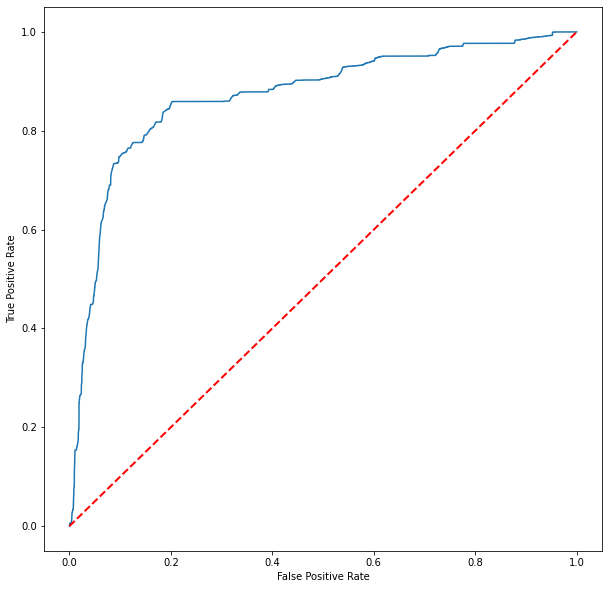

<function matplotlib.pyplot.show(close=None, block=None)>

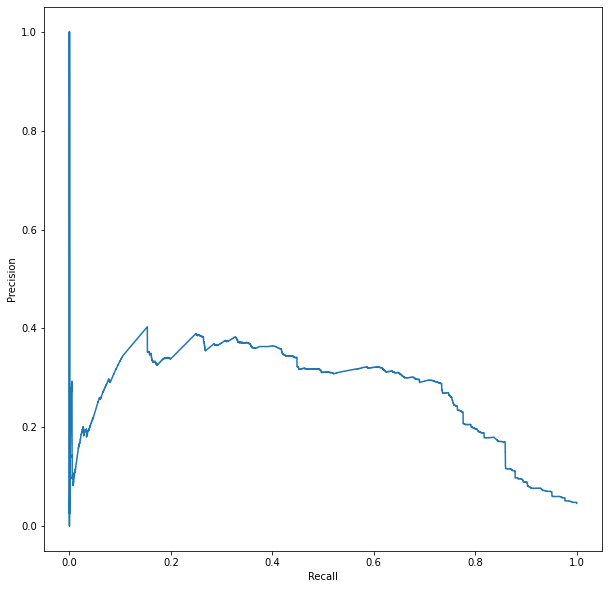

In [20]:
# auroc curve
plt.figure(figsize=(10, 10))
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', label='Random guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# plt.savefig('{}/auroc.png'.format(tempdir))
# plt.close()
plt.show()

# auprc curve
plt.figure(figsize=(10, 10))
plt.plot(recall, precision)
plt.xlabel('Recall')
plt.ylabel('Precision')
#plt.savefig('{}/auprc.png'.format(tempdir))
# plt.close()
plt.show


## Plotting each case in the test dataset

146/146 [==============================] - 2s 13ms/step
Print error: 5167	0.2674536032414182	


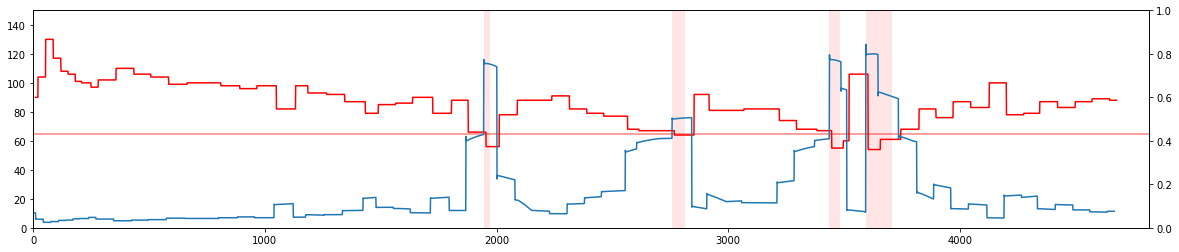

112/112 [==============================] - 2s 13ms/step
Print error: 5206	0.127152184168964	


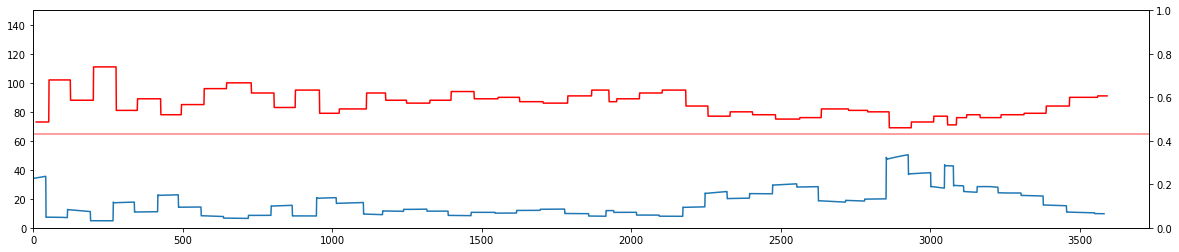

58/58 [==============================] - 1s 15ms/step
Print error: 5229	0.25129814177800264	


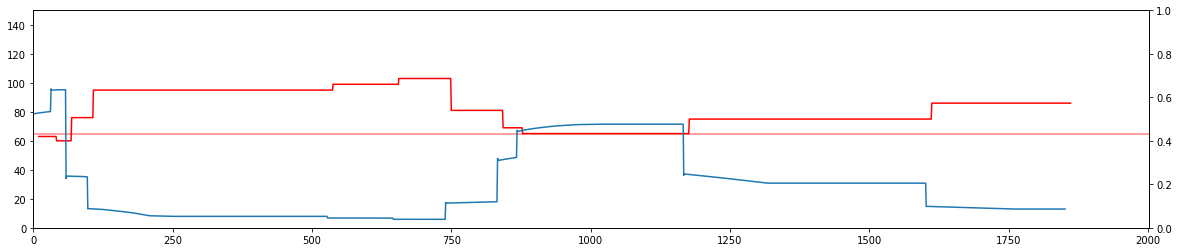

99/99 [==============================] - 4s 35ms/step
Print error: 5279	0.3729262431564933	


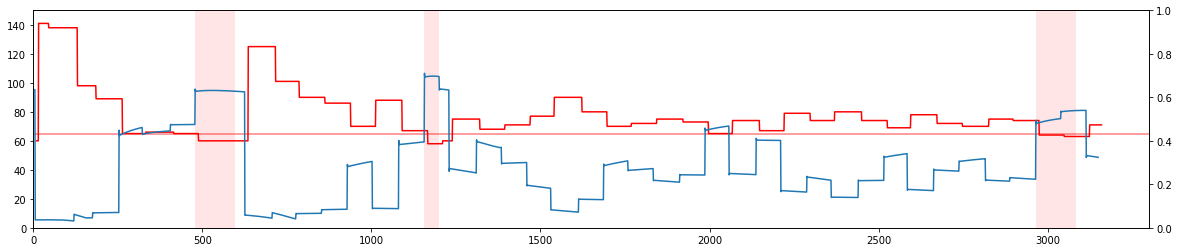

39/39 [==============================] - 2s 54ms/step
Print error: 5293	0.4761748378745976	


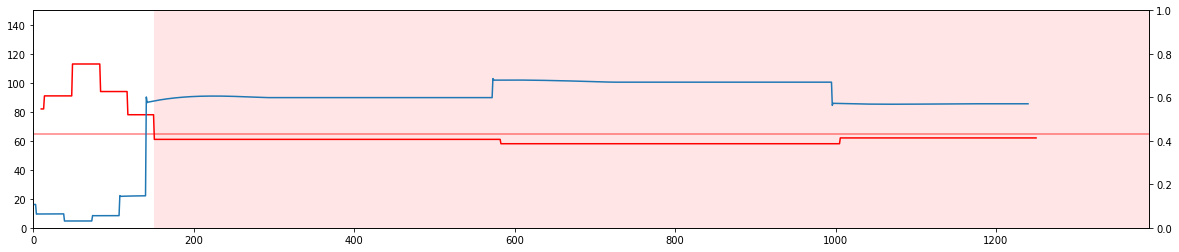

186/186 [==============================] - 6s 33ms/step
Print error: 5361	0.24157798115421475	


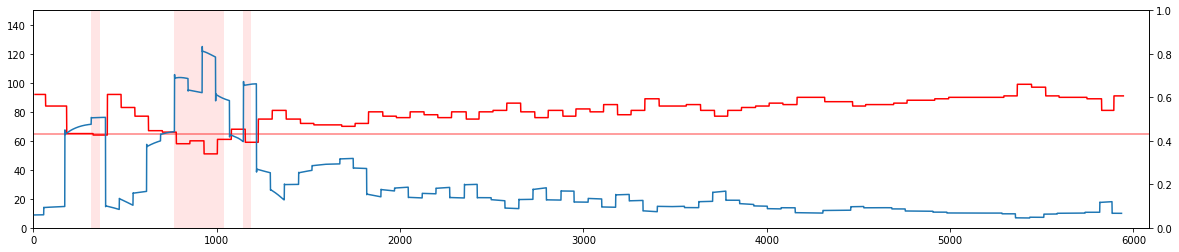

60/60 [==============================] - 2s 27ms/step
Print error: 5423	0.13295832510177785	


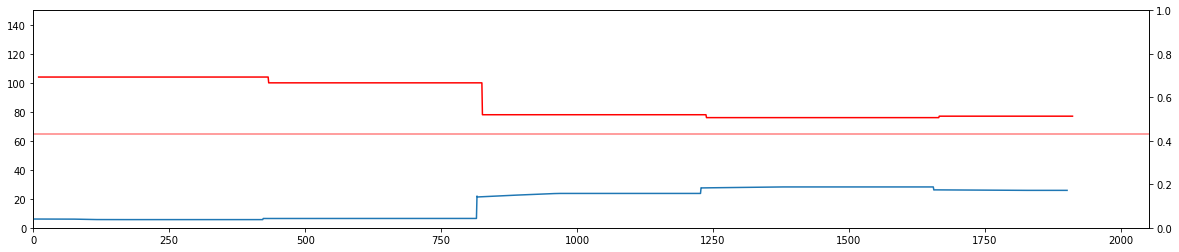

148/148 [==============================] - 5s 32ms/step
Print error: 5506	0.22598442782707576	


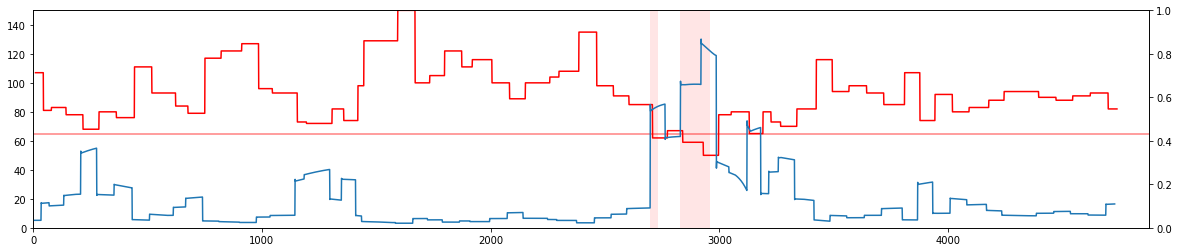

62/62 [==============================] - 1s 21ms/step
Print error: 5509	0.08196859578275553	


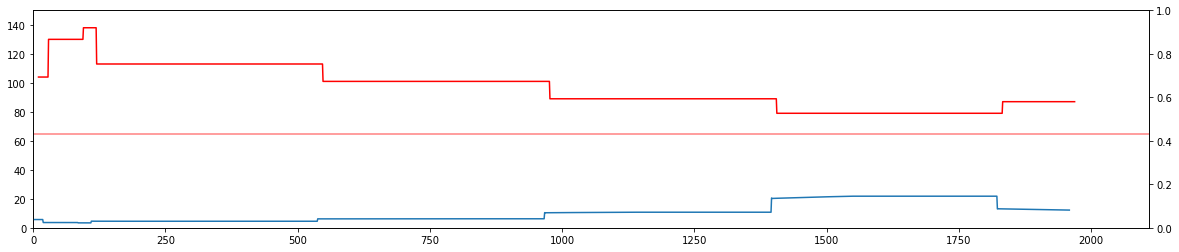

146/146 [==============================] - 3s 20ms/step
Print error: 5516	0.1645479683112076	


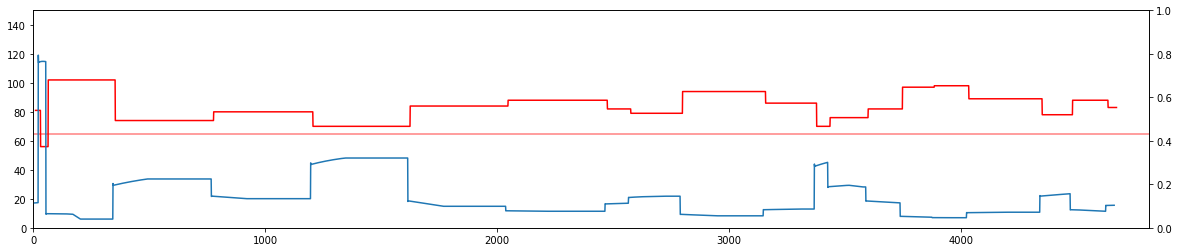

83/83 [==============================] - 2s 21ms/step
Print error: 5582	0.26251672680105165	


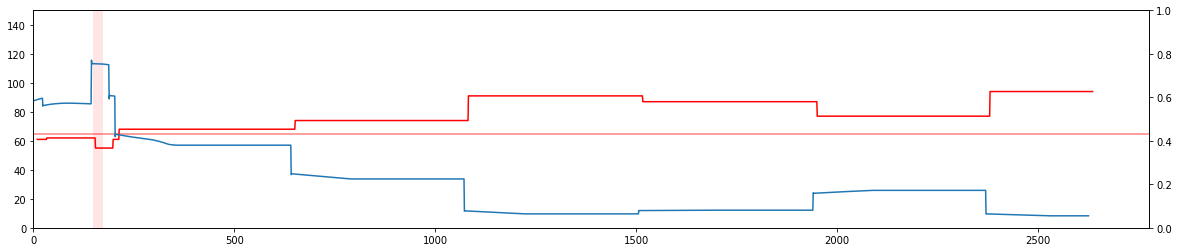

235/235 [==============================] - 8s 34ms/step
Print error: 5596	0.08203568333044636	


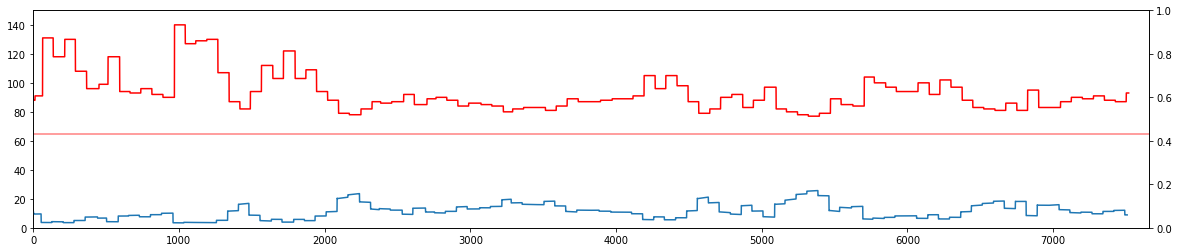

55/55 [==============================] - 2s 30ms/step
Print error: 5600	0.04351835264135875	


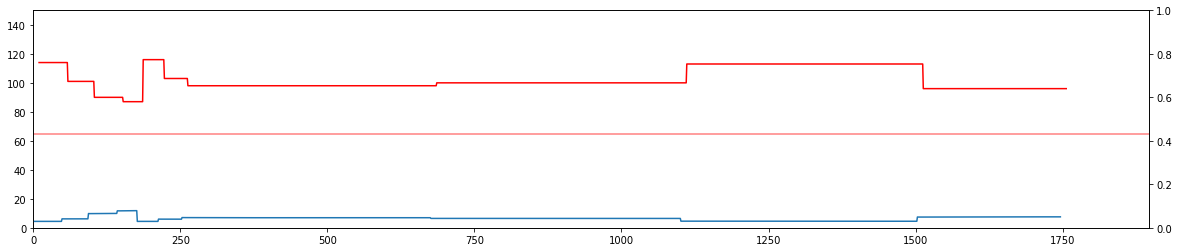

48/48 [==============================] - 2s 31ms/step
Print error: 5627	0.20693629264421726	


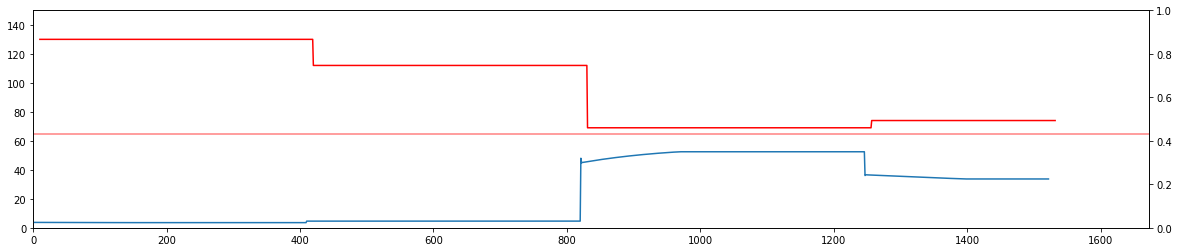

162/162 [==============================] - 5s 28ms/step
Print error: 5639	0.30788970259881815	


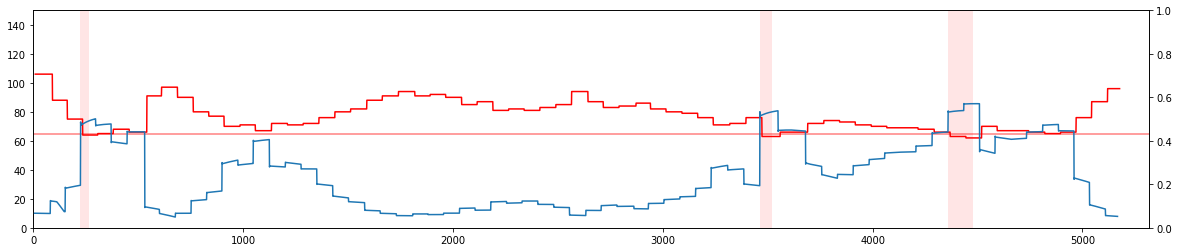

86/86 [==============================] - 2s 18ms/step
Print error: 5672	0.27725184623767424	


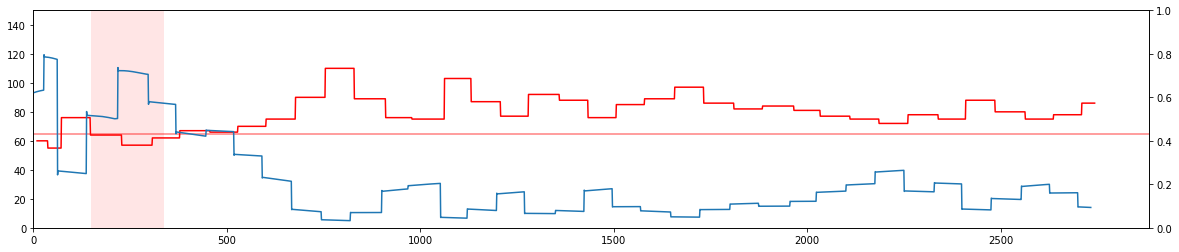

203/203 [==============================] - 3s 16ms/step
Print error: 5716	0.15225020006085235	


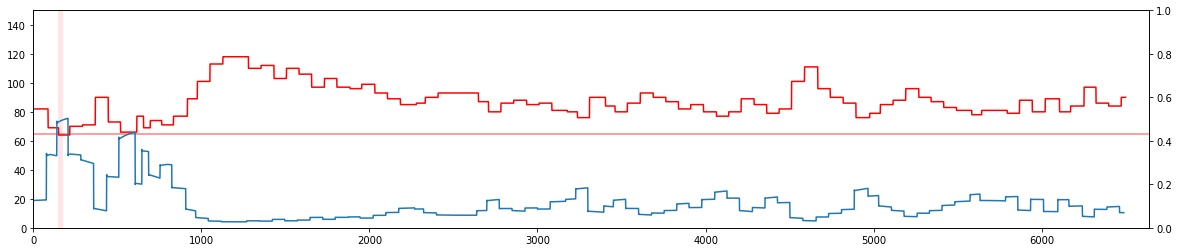

268/268 [==============================] - 5s 19ms/step
Print error: 5786	0.22881549331480572	


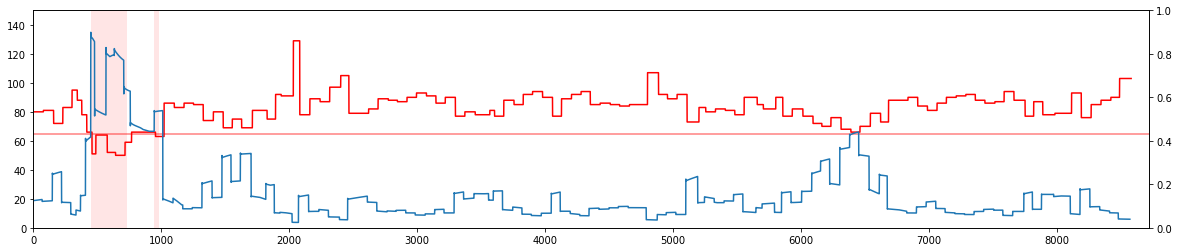

136/136 [==============================] - 4s 32ms/step
Print error: 5821	0.24476309196946458	


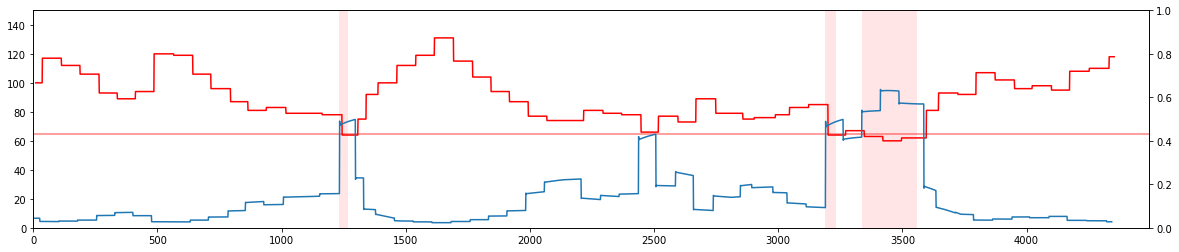

109/109 [==============================] - 4s 39ms/step
Print error: 5927	0.07070635714440636	


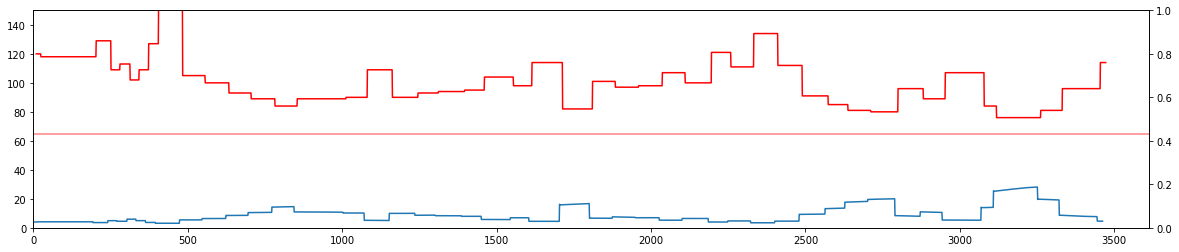

119/119 [==============================] - 4s 33ms/step
Print error: 5949	0.3557264839879202	


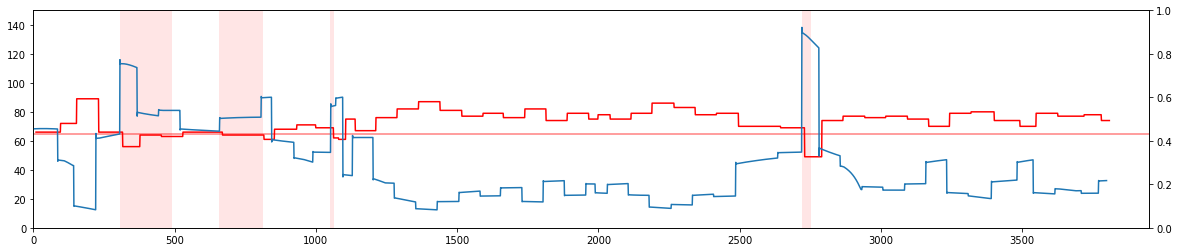

91/91 [==============================] - 2s 17ms/step
Print error: 6023	0.29171762986215855	


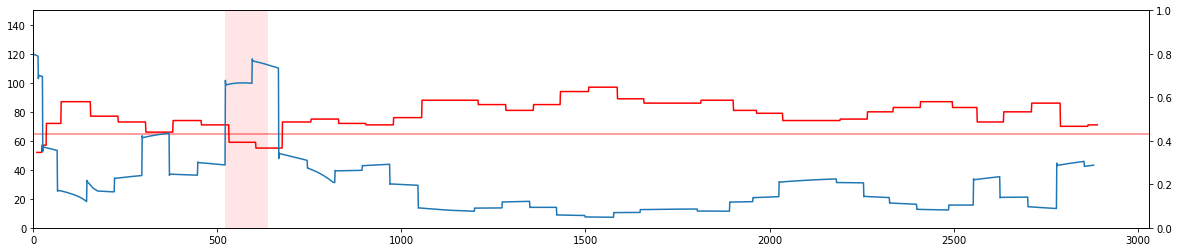

113/113 [==============================] - 4s 31ms/step
Print error: 6036	0.18720483395556045	


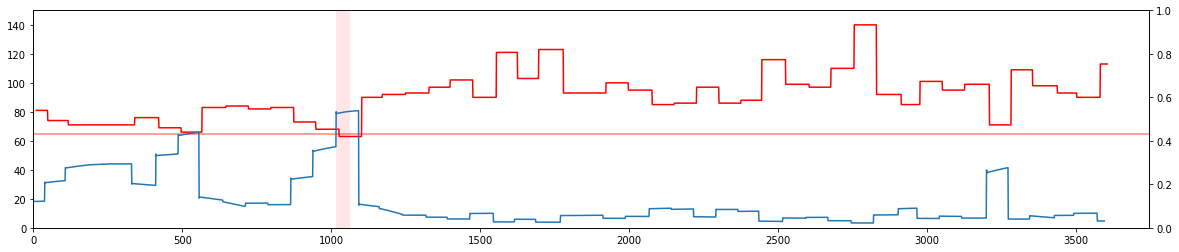

79/79 [==============================] - 2s 26ms/step
Print error: 6045	0.17953491989050133	


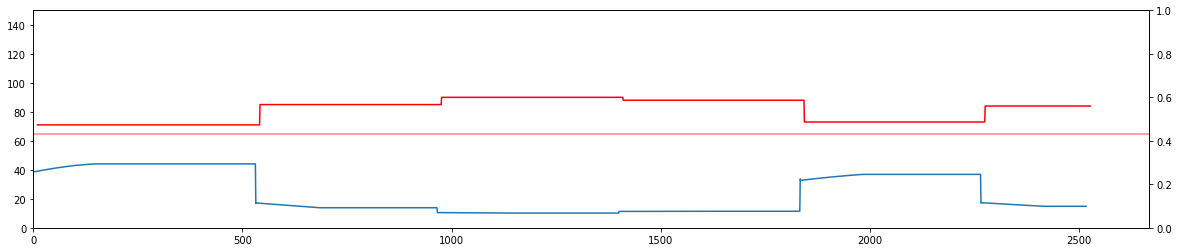

48/48 [==============================] - 2s 32ms/step
Print error: 6116	0.1328383869299118	


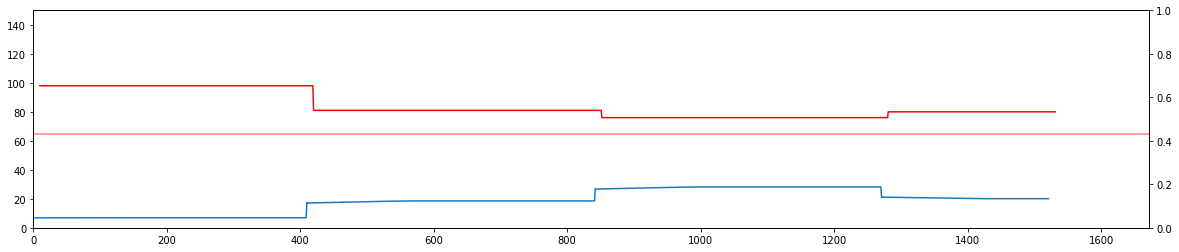

242/242 [==============================] - 7s 28ms/step
Print error: 6146	0.37556387310313494	


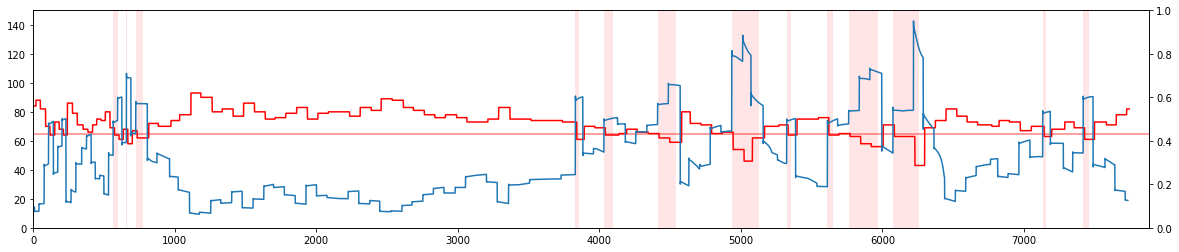

141/141 [==============================] - 3s 23ms/step
Print error: 6241	0.1800106811831273	


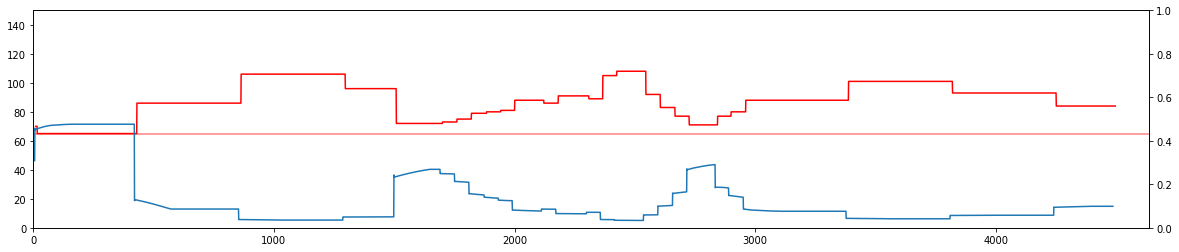

239/239 [==============================] - 9s 38ms/step
Print error: 6253	0.08278632627578447	


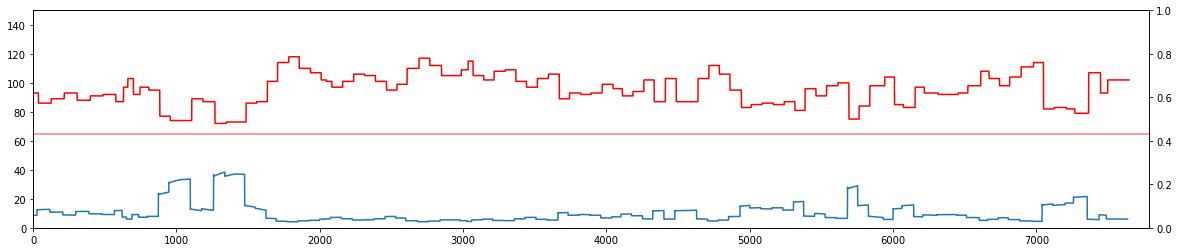

219/219 [==============================] - 6s 27ms/step
Print error: 6294	0.18972365737019745	


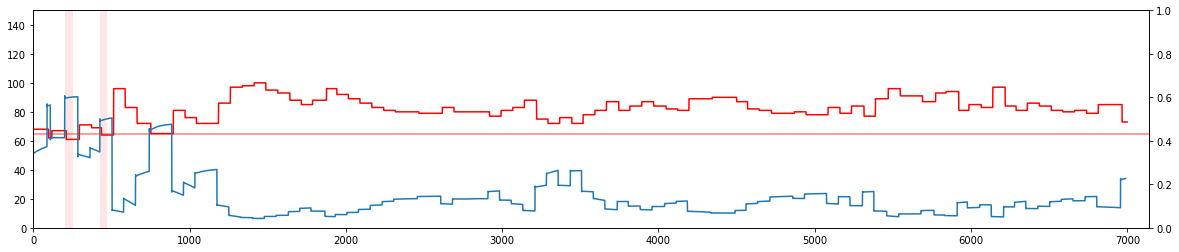

112/112 [==============================] - 4s 30ms/step
Print error: 6321	0.18952800804566935	


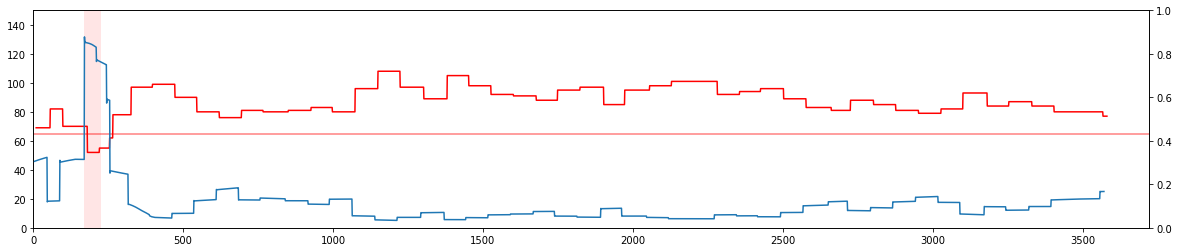

89/89 [==============================] - 2s 20ms/step
Print error: 6385	0.4247187560413173	


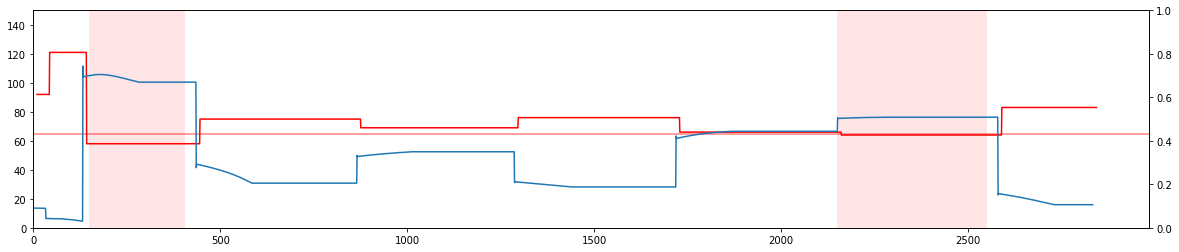

In [21]:
for caseid in caseids_test:
    case_mask = (c == caseid)
    case_len = np.sum(case_mask)
    if case_len == 0:
        continue

    case_x = x[case_mask]
    case_y = y[case_mask]
    case_valid_mask = valid_mask[case_mask]
    
    # calculate error for this case
    case_predy = model.predict(case_x).flatten()
    case_rmse = np.nanmean((case_y - case_predy) ** 2) ** 0.5
    print('Print error:', '{}\t{}\t'.format(caseid, case_rmse))

    # draw
    plt.figure(figsize=(20, 4))
    plt.xlim([0, case_len + MINUTES_AHEAD * 30])
    t = np.arange(0, case_len)

    # red bars for the event
    ax1 = plt.gca()
    for i in range(len(case_y)):
        if case_y[i]:
            ax1.axvspan(i + MINUTES_AHEAD * 30, i + MINUTES_AHEAD * 30 + 1, color='r', alpha=0.1, lw=0)

    # 65 mmHg bar
    ax1.axhline(y=65, color='r', alpha=0.5)
    ax1.plot(t + 10, case_x[:,-1], color='r')
    ax1.set_ylim([0, 150])

    ax2 = ax1.twinx()
    
    # draw valid samples
    case_predy[~case_valid_mask] = np.nan
    ax2.plot(t, case_predy)
    ax2.set_ylim([0, 1])
    
    # save
    plt.show()